In [1]:
# For training 
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import dlc_practical_prologue as prologue
import time

# For visualisation and performance analysis
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import interpolate

# Global parameters

In [2]:
#For reproductibility
SEED = 123 
torch.manual_seed(SEED)

if torch.cuda.is_available(): 
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Device used: {}'.format(DEVICE))

# Training parameters
N = 1000 #Dataset size (train and test)
BATCH_SIZE = 25 #Batch size for stochastic optimization
EPOCHS = 200 # Number of epochs for one round of training
VERBOSE_FREQ = 10 # Show verbose every VERBOSE_FREQ epochs
ROUNDS = 15 # Number of rounds for validation and for the auxiliary loss analysis

#Learing rate evolution (multiply LEARNING_RATE by GAMMA every LR_STEP epochs)
LEARNING_RATE = 1e-3 
LR_STEP = int(0.5 * EPOCHS)
GAMMA = 0.1

# Auxiliary and main losses ponderation (allowing for semi-dynamic loss weighting)
AUX_LOSS_I = 0.5
AUX_LOSS_F = 0.5
AUX_LOSS_STEP = int(0.5 * EPOCHS)

# Number of different auxiliary loss tested for the auxiliary loss analysis
NB_AL_EVAL = 21 

Device used: cpu


# Data loading

Data statistics function.

In [3]:
def data_statistics(train_input, train_target, train_classes, test_input, test_target, test_classes):
    """Print some statistics on the data."""
    print("Train data:\n"
          "   -Input size: {}\n".format(train_input.shape) + \
          "   -Target size: {}\n".format(train_target.shape) + \
          "   -Classes size: {}\n".format(train_classes.shape) + \
          "   -Fraction of positive: {:.2f}%\n".format(100 * train_target.sum().item()/train_input.shape[0]))
    print("Test data:\n"
          "   -Input size: {}\n".format(test_input.shape) + \
          "   -Target size: {}\n".format(test_target.shape) + \
          "   -Classes size: {}\n".format(test_classes.shape) + \
          "   -Fraction of positive: {:.2f}%\n".format(100 * test_target.sum().item()/test_input.shape[0]))

def sample_showcase(idx, inputs, targets, classes):
    """Show one of the data point with its corresponding target and classes."""
    n1_img, n2_img =  inputs[idx,0,:,:], inputs[idx,1,:,:]
    t = targets[idx]
    c1, c2 = classes[idx,0], classes[idx,1]
    
    plt.figure(figsize=(6, 3.7))
    plt.suptitle('Sample {} (target = {})'.format(idx, t))
        
    plt.subplot(121)
    plt.title('First channel\n (class = {})'.format(c1))
    plt.imshow(n1_img, cmap='Greys')
    
    plt.subplot(122)
    plt.title('Secont channel\n (class = {})'.format(c2))
    plt.imshow(n2_img, cmap='Greys')
   


In [4]:
# Load data 
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)

train_input, train_target, train_classes = train_input.to(DEVICE), train_target.to(DEVICE), train_classes.to(DEVICE)
test_input, test_target, test_classes = test_input.to(DEVICE), test_target.to(DEVICE), test_classes.to(DEVICE)

Train data:
   -Input size: torch.Size([1000, 2, 14, 14])
   -Target size: torch.Size([1000])
   -Classes size: torch.Size([1000, 2])
   -Fraction of positive: 55.60%

Test data:
   -Input size: torch.Size([1000, 2, 14, 14])
   -Target size: torch.Size([1000])
   -Classes size: torch.Size([1000, 2])
   -Fraction of positive: 56.40%



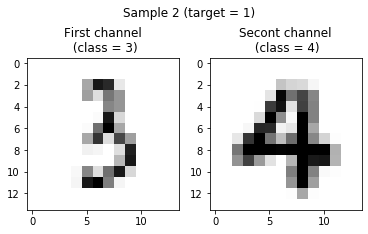

In [5]:
# Print data statistics
data_statistics(train_input, train_target, train_classes, test_input, test_target, test_classes)

# Showcase of one sample
sample_showcase(2, train_input, train_target, train_classes)

# Helper functions

Accuracy functions.

In [6]:
def accuracy(model_output, test_target):
    """Return the accuracy of the model output."""
    nb_samples = model_output.shape[0]
    output_int = torch.zeros(nb_samples)
    
    # Convert probability to decision
    output_int = torch.argmax(model_output, 1)
    
    nb_errors = (output_int - test_target).type(torch.BoolTensor).sum().item()
    return (nb_samples - nb_errors) / nb_samples

def accuracyMnist(model_output, test_target):
    """Return the accuracy of the predicted digits of a Digit Net."""
    nb_samples = model_output.shape[0]
    model_class = model_output.argmax(dim=1)
    nb_errors = (model_class - test_target).type(torch.BoolTensor).sum().item()
    return (nb_samples - nb_errors) / nb_samples

Function to reset weights

In [7]:
def weight_reset(m):
    """Reset the parameters of the model"""
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

Auxiliary loss ponderation

In [8]:
def aux_loss_coeff(e, f_forced=None):
    """ Return the weight of the auxiliary (f) and main (1-f) loss at epoch e."""
    if f_forced is not None:
        return f_forced

    f = AUX_LOSS_I
    if e >= AUX_LOSS_STEP:
        f = AUX_LOSS_F
            
    return f

Function that returns the nb of parameters of a given model

In [9]:
def nb_param(model):
    """Return the number of trained parameters of the input model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Functions to store variables (backup)

In [10]:
import pickle

def save_pkl(obj, name):
    """Store the input object under ./backup/name."""
    f = open('./backup/' + name, 'wb')
    pickle.dump(obj, f)
    f.close()

def load_pkl(name):
    """Load an object from ./backup/name."""
    f = open('./backup/' + name, 'rb')
    obj = pickle.load(f)
    f.close()
    
    return obj


# Neural Nets Definition

Fully Connected Nets (trials)

In [11]:
class NaiveNetV1(nn.Module):
    """Naive fully connected net."""
    def __init__(self):
        super(NaiveNetV1, self).__init__()
        self.fc1 = nn.Linear(392,98)
        self.fc2 = nn.Linear(98,98)
        self.fc3 = nn.Linear(98,20)
        self.fc4 = nn.Linear(20,2)
        
        self.drop = nn.Dropout(0.25)
        self.activ = F.relu
   
    def forward(self, x):
        x = self.fc1(x.view(x.size(0),-1))
        x = self.activ(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.activ(x)
        x = self.drop(x)
        x = self.fc3(x)
        x1, x2 = x[:, 0:10], x[:, 10:20]
        x = self.activ(x)
        x = self.fc4(x)
        
        return x, x1, x2
    
class NaiveNetV2(nn.Module):
    """Naive fully connected net."""
    def __init__(self):
        super(NaiveNetV2, self).__init__()
        self.fc1 = nn.Linear(392,196)
        self.fc2 = nn.Linear(196,196)
        self.fc3 = nn.Linear(196,196)
        self.fc4 = nn.Linear(196,196)
        self.fc5 = nn.Linear(196,20)
        self.fc6 = nn.Linear(20,2)
        
        self.drop = nn.Dropout(0.5)
        self.activ = F.relu
   
    def forward(self, x):
        x = self.fc1(x.view(x.size(0),-1))
        x = self.activ(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.activ(x)
        x = self.drop(x)
        x = self.fc3(x)        
        x = self.activ(x)
        x = self.drop(x)
        x = self.fc4(x)
        x = self.activ(x)
        x = self.drop(x)
        x = self.fc5(x)
        x1, x2 = x[:, 0:10], x[:, 10:20]
        x = self.activ(x)
        x = self.fc6(x)        
        
        return x, x1, x2

Convolutional Nets (trials)

In [12]:
class MnistNetV1(nn.Module):
    """First iteration of a relatively complex convolutional network."""
    def __init__(self):
        super(MnistNetV1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=1) #(1,14,14) to (32,12,12)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) #(32,12,12) to (64,10,10)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #(64,10,10) to (64,5,5)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=2) #(64,5,5) to (128,4,4) 
        self.max_pool2 = nn.MaxPool2d(kernel_size=3, stride=1) #(128,4,4) to (128,2,2)
        self.fc = nn.Linear(512, 10)
        self.drop2d = nn.Dropout2d(0.25)

    def forward(self, x):   
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.drop2d(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = self.drop2d(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x, None, None

class MnistNetV2(nn.Module):
    """Second iteration of a relatively complex convolutional network."""
    def __init__(self):
        super(MnistNetV2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) #(1,14,14) to (32,12,12)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3) #(32,12,12) to (64,10,10)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #(64,10,10) to (64,5,5)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.drop25 = nn.Dropout(0.25)
        self.drop50 = nn.Dropout(0.5)
        
    def forward(self, x):   
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.drop25(x.view(x.size(0), -1))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop50(x)
        x = self.fc2(x)
        
        return x, None, None


class MnistNetV3(nn.Module):
    """Inspired by LeNet4"""
    def __init__(self):
        super(MnistNetV3, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3) #(1,14,14) to (4,12,12)
        self.conv2 = nn.Conv2d(4, 16, kernel_size=3) #(4,12,12) to (16,10,10)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #(16,10,10) to (16,5,5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 10)
        
        self.drop25 = nn.Dropout(0.25)
        self.drop50 = nn.Dropout(0.5)
        
    def forward(self, x):   
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.drop50(x.view(x.size(0), -1))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop50(x)
        x = self.fc2(x)
        
        return x, None, None


class MnistNetV4(nn.Module):
    """Inspired by LeNet5, dropout 0.25."""
    def __init__(self):
        super(MnistNetV4
              , self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3) #(1,14,14) to (6,12,12)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3) #(6,12,12) to (16,10,10)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #(16,10,10) to (16,5,5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)
        
        self.drop = nn.Dropout(0.25)
        
    def forward(self, x):   
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.drop(x.view(x.size(0), -1))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc3(x)
        
        return x, None, None

class MnistNetV5(nn.Module):
    """Inspired by LeNet5, dropout 0.5."""
    def __init__(self):
        super(MnistNetV5
              , self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=3) #(1,14,14) to (6,12,12)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=3) #(6,12,12) to (16,10,10)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #(16,10,10) to (16,5,5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 10)
        
        self.drop = nn.Dropout(0.5)
        
    def forward(self, x):   
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.drop(x.view(x.size(0), -1))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc3(x)
        
        return x, None, None

    
class MnistNetV7(nn.Module):
    """Inspired by LeNet5, dropout 0.5 and 3 fc layers"""
    def __init__(self):
        super(MnistNetV7, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=3) #(1,14,14) to (12,12,12)
        self.conv2 = nn.Conv2d(12, 32, kernel_size=3) #(12,12,12) to (32,10,10)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #(32,10,10) to (32,5,5)
        self.fc1 = nn.Linear(800, 400)
        self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(100, 10)
        
        self.drop = nn.Dropout(0.5)
        
    def forward(self, x):   
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.drop(x.view(x.size(0), -1))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc3(x)
        
        return x, None, None


class MnistNetV8(nn.Module):
    """Inspired by LeNet5, dropout 0.5 and 2 fc layers."""
    def __init__(self):
        super(MnistNetV8, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=3) #(1,14,14) to (12,12,12)
        self.conv2 = nn.Conv2d(12, 32, kernel_size=3) #(12,12,12) to (32,10,10)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #(32,10,10) to (32,5,5)
        self.fc1 = nn.Linear(800, 100)
        self.fc2 = nn.Linear(100, 10)

        
        self.drop = nn.Dropout(0.5)
        
    def forward(self, x):   
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.drop(x.view(x.size(0), -1))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        
        return x, None, None
    
class ConvNetV1(nn.Module):
    """Naive convolutional net."""
    def __init__(self):
        super(ConvNetV1, self).__init__()
        self.conv1 = nn.Conv2d(2, 8, kernel_size=3) #(1,14,14) to (12,12,12)
        self.conv2 = nn.Conv2d(8, 24, kernel_size=3) #(12,12,12) to (32,10,10)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #(32,10,10) to (32,5,5)
        self.conv3 = nn.Conv2d(24, 48, kernel_size=2) #(32,5,5) to (48,4,4)
        self.fc1 = nn.Linear(768, 100)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 2)
        
        self.drop = nn.Dropout(0.5)
        
    def forward(self, x):   
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.drop(x.view(x.size(0), -1))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x1, x2 = x[:, 0:10], x[:, 10:20]
        x = F.relu(x)
        x = self.fc3(x)
        
        return x, x1, x2
    

class ConvNetV2(nn.Module):
    """Naive convolutional net."""
    def __init__(self):
        super(ConvNetV2, self).__init__()
        self.conv1 = nn.Conv2d(2, 8, kernel_size=3) #(1,14,14) to (8,12,12)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3) #(8,12,12) to (16,10,10)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #(16,10,10) to (16,5,5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 20)
        self.fc4 = nn.Linear(20, 2)
        
        self.drop = nn.Dropout(0.5)
    
    def forward(self, x):   
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.drop(x.view(x.size(0), -1))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc3(x)
        x1, x2 = x[:, 0:10], x[:, 10:20]
        x = F.relu(x)
        #x = self.drop(x)
        x = self.fc4(x)
        
        return x, x1, x2

Recombination Nets (trials)

In [13]:
class BasicNetV1(nn.Module):
    """MnistNet with two fully connected layers (20->20 and 20->2)."""
    def __init__(self):
        super(BasicNetV1, self).__init__()
        self.mnistNet = MnistNetV4()
        self.fc1 = nn.Linear(20,20)
        self.fc2 = nn.Linear(20,2)


    def forward(self, x):
        x1, x2 = x[:,0:1,:,:], x[:,1:2,:,:]
        x1, _, _ = self.mnistNet(x1)
        x2, _, _ = self.mnistNet(x2)       
        x = torch.cat((x1, x2), 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x, x1, x2
    
class BasicNetV2(nn.Module):
    """MnistNet with two fully connected layers (20->10->2). No Dropout"""
    def __init__(self):
        super(BasicNetV2, self).__init__()
        self.mnistNet = MnistNetV7()
        self.fc1 = nn.Linear(20,10)
        self.fc2 = nn.Linear(10,2)


    def forward(self, x):
        x1, x2 = x[:,0:1,:,:], x[:,1:2,:,:]
        x1, _, _ = self.mnistNet(x1)
        x2, _, _ = self.mnistNet(x2)       
        x = torch.cat((x1, x2), 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x, x1, x2
    
class BasicNetV3(nn.Module):
    """MnistNet with two fully connected layers (20->10->2). No Dropout"""
    def __init__(self):
        super(BasicNetV3, self).__init__()
        self.mnistNet = MnistNetV5()
        self.fc1 = nn.Linear(20,20)
        self.fc2 = nn.Linear(20,2)


    def forward(self, x):
        x1, x2 = x[:,0:1,:,:], x[:,1:2,:,:]
        x1, _, _ = self.mnistNet(x1)
        x2, _, _ = self.mnistNet(x2)       
        x = torch.cat((x1, x2), 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x, x1, x2

Nets presented in the report

In [14]:
class FCNet(nn.Module):
    """Naive fully connected net."""
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(392,200)
        self.fc2 = nn.Linear(200,20)
        self.fc3 = nn.Linear(20,2)
        
        self.drop = nn.Dropout(0.25)
        self.activ = F.relu

    def forward(self, x):
        x = self.fc1(x.view(x.size(0),-1))
        x = self.activ(x)
        x = self.drop(x)
        x = self.fc2(x)
        x1, x2 = x[:, 0:10], x[:, 10:20]
        x = self.activ(x)
        x = self.fc3(x)
        
        return x, x1, x2

class ConvNet(nn.Module):
    """Naive convolutional net."""
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 12, kernel_size=3) #(1,14,14) to (12,12,12)
        self.conv2 = nn.Conv2d(12, 32, kernel_size=3) #(12,12,12) to (32,10,10)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #(32,10,10) to (32,5,5)
        self.fc1 = nn.Linear(800, 100)
        self.fc2 = nn.Linear(100, 20)
        self.fc3 = nn.Linear(20, 2)
        
        self.drop = nn.Dropout(0.5)
        
    def forward(self, x):   
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.drop(x.view(x.size(0), -1))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x1, x2 = x[:, 0:10], x[:, 10:20]
        x = F.relu(x)
        x = self.fc3(x)
        
        return x, x1, x2

class DigitNet(nn.Module):
    """Inspired by LeNet5, dropout 0.5 and 2 fc layers."""
    def __init__(self):
        super(DigitNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=3) #(1,14,14) to (12,12,12)
        self.conv2 = nn.Conv2d(12, 32, kernel_size=3) #(12,12,12) to (32,10,10)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #(32,10,10) to (32,5,5)
        self.fc1 = nn.Linear(800, 100)
        self.fc2 = nn.Linear(100, 10)
        self.drop = nn.Dropout(0.5)
        
    def forward(self, x):   
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.drop(x.view(x.size(0), -1))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x
    

class ConvSepNet(nn.Module):
    """Run DigitNet in parrallel on each chanel and combine at the
    end with two fully connected layers (20->10->2). No Dropout in the f.c. layers.
    """
    def __init__(self):
        super(ConvSepNet, self).__init__()
        self.mnistNet = DigitNet()
        self.fc1 = nn.Linear(20,10)
        self.fc2 = nn.Linear(10,2)


    def forward(self, x):
        x1, x2 = x[:,0:1,:,:], x[:,1:2,:,:]
        x1 = self.mnistNet(x1)
        x2 = self.mnistNet(x2)       
        x = torch.cat((x1, x2), 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x, x1, x2
    

class FinalDigitNet(nn.Module):
    """Inspired by LeNet5, dropout 0.5 and 3 fc layers"""
    def __init__(self):
        super(FinalDigitNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size=3) #(1,14,14) to (12,12,12)
        self.conv2 = nn.Conv2d(12, 32, kernel_size=3) #(12,12,12) to (32,10,10)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #(32,10,10) to (32,5,5)
        self.fc1 = nn.Linear(800, 400)
        self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(100, 10)
        
        self.drop = nn.Dropout(0.5)
        
    def forward(self, x):   
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.drop(x.view(x.size(0), -1))
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc3(x)
        
        return x
    
class FinalNet(nn.Module):
    """DigitNet with two fully connected layers (20->10->2). No Dropout"""
    def __init__(self):
        super(FinalNet, self).__init__()
        self.mnistNet = FinalDigitNet()
        self.fc1 = nn.Linear(20,10)
        self.fc2 = nn.Linear(10,2)


    def forward(self, x):
        x1, x2 = x[:,0:1,:,:], x[:,1:2,:,:]
        x1 = self.mnistNet(x1)
        x2 = self.mnistNet(x2)       
        x = torch.cat((x1, x2), 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x, x1, x2

In [15]:
# Model constructions
myFCNet = FCNet().to(DEVICE)
myConvNet = ConvNet().to(DEVICE)
myConvSepNet = ConvSepNet().to(DEVICE)
myFinalNet = FinalNet().to(DEVICE)

print('Number of parameters:\n' + \
      '  -FCNet: {}\n'.format(nb_param(myFCNet)) + \
      '  -ConvNet: {}\n'.format(nb_param(myConvNet)) + \
      '  -ConvSepNet: {}\n'.format(nb_param(myConvSepNet)) + \
      '  -FinalNet: {}\n'.format(nb_param(myFinalNet)))

Number of parameters:
  -FCNet: 82662
  -ConvNet: 85878
  -ConvSepNet: 84950
  -FinalNet: 365350



# Training

Verbose and summary rountine for the main training routine.

In [16]:
def verbose_routine(model, criterion, epoch,
                    train_input, train_target, train_classes,
                    test_input, test_target, test_classes):
    """Display verbose during the current epoch."""
    # Compute model outputs
    model.train(False)
    tr_output, tr_aux1, tr_aux2 = model(train_input)
    te_output, te_aux1, te_aux2 = model(test_input)
    model.train(True) 

    # Compute performance using model outputs
    tr_loss = criterion(tr_output, train_target)
    te_loss = criterion(te_output, test_target)
    
    tr_acc = accuracy(tr_output, train_target)
    te_acc = accuracy(te_output, test_target)
    
    tr_acc_mnist = 0.5*(accuracyMnist(tr_aux1, train_classes[:,0]) +\
                           accuracyMnist(tr_aux2, train_classes[:,1]))
    te_acc_mnist = 0.5*(accuracyMnist(te_aux1, test_classes[:,0]) +\
                         accuracyMnist(te_aux2, test_classes[:,1]))

    # Display result
    print("Epoch {}:\n".format(epoch) + \
          "Train loss : {:.3f},      |   Test loss : {:.6f}\n".format(tr_loss, te_loss) +\
          "Train acc : {:.3f},       |   Test acc : {:.3f}\n".format(tr_acc, te_acc) +\
          "Train acc mnist : {:.3f}, |   Test acc mnist : {:.3f}\n".format(tr_acc_mnist, te_acc_mnist) +\
          "-----------")

In [17]:
def summary_routine(model, track_history, verbose, f_forced, history):
    """Print summary of the model properties and performance at the end of the training."""
    total_trained_params = sum(p.numel() for p in model.parameters())

    # Training time relevance
    warning =""
    if track_history or verbose:
        if not verbose:
            warning = "(history active)"
        elif not track_history:
            warning = "(verbose active)"
        else:
            warning = "(history and verbose active)"
    
    if f_forced is None:
        AL_log = "Weight of auxiliary loss: {} before epoch {} and {} after\n".format(AUX_LOSS_I, AUX_LOSS_STEP, AUX_LOSS_F)
    else:
        AL_log = "Weight of auxiliary loss: {}\n".format(f_forced)
            
    print("Model : {}\n".format(model.__class__.__name__) + \
          "Number of trained parameters : {}\n".format(total_trained_params) + \
          "Train data size : {}\n".format(N) + \
          "Seed for reproductibility : {}\n".format(SEED) + \
          "Size of mini-batches : {}\n".format(BATCH_SIZE) + \
          "Learning rate : {} (multiplied by {} every {} epochs)\n".format(LEARNING_RATE, GAMMA, LR_STEP) + \
          AL_log + \
          "Time for {} epochs : {:.2f}s {}\n".format(EPOCHS, history["t_elapsed"], warning) + \
          "Main performance:\n" + \
          "    -Train accuracy : {:.2f}%\n".format(100 * history["tr_acc_hist"][-1]) + \
          "    -Test accuracy : {:.2f}%\n".format(100 * history["te_acc_hist"][-1]) + \
          "Auxiliary performance:\n" + \
          "    -Train Mnist accuracy : {:.2f}%\n".format(100 * history["tr_acc_mnist_hist"][-1]) + \
          "    -Test Mnist accuracy : {:.2f}%\n".format(100 * history["te_acc_mnist_hist"][-1]) + \
          "-----------------------------------")

Dictionaries initialization routine and update routine for history.

In [18]:
def dictionary_init(track_history, rounds=False, AL_eval=False):
    """Initialize the histroy (or round statistics) dictionary."""
    # For history dictionary
    sz_time = int(rounds) # For history dictionaries, history["t_elapsed"] will be overriden by a float and sz_time doesn't matter. 
    if not AL_eval:
        if not rounds:
            if track_history:
                sz = EPOCHS # Store performance at each epoch
            else:
                sz = 1 # Store only the final performance

        # For rounds stats dictionary
        else:
            if track_history:
                sz = (rounds,EPOCHS) # Store performance at each round and epoch 
            else:
                sz = (rounds,1) # Store only the final performance for each round
    else:
        sz = (rounds, NB_AL_EVAL)
    # Arrays to store history of performance during training (or only last value if history is False)
    dictionary = {
    "tr_loss_hist" : torch.zeros(sz),
    "te_loss_hist" : torch.zeros(sz),
    "tr_acc_hist" : torch.zeros(sz),
    "te_acc_hist" : torch.zeros(sz),
    "tr_acc_mnist_hist" : torch.zeros(sz),
    "te_acc_mnist_hist" : torch.zeros(sz),
    "t_elapsed" : torch.zeros(sz_time)}
    
    return dictionary

In [19]:
def history_routine_(history, model, criterion, idx,
                     train_input, train_target, train_classes,
                     test_input, test_target, test_classes):
    """Update (in place) the model performance history at epoch."""
    # Compute model outputs
    model.train(False)
    tr_output, tr_aux1, tr_aux2 = model(train_input)
    te_output, te_aux1, te_aux2 = model(test_input)
    model.train(True) 

    # Compute performance using model outputs
    tr_loss = criterion(tr_output, train_target).detach()
    te_loss = criterion(te_output, test_target).detach()
    
    tr_acc = accuracy(tr_output, train_target)
    te_acc = accuracy(te_output, test_target)
    
    tr_acc_mnist = 0.5*(accuracyMnist(tr_aux1, train_classes[:,0]) + \
                           accuracyMnist(tr_aux2, train_classes[:,1]))
    te_acc_mnist = 0.5*(accuracyMnist(te_aux1, test_classes[:,0]) + \
                         accuracyMnist(te_aux2, test_classes[:,1]))
    
    # Updating history tensors
    history["tr_loss_hist"][idx] = tr_loss
    history["te_loss_hist"][idx] = te_loss
    history["tr_acc_hist"][idx] = tr_acc
    history["te_acc_hist"][idx] = te_acc
    history["tr_acc_mnist_hist"][idx] = tr_acc_mnist
    history["te_acc_mnist_hist"][idx] = te_acc_mnist

Main train routine.

In [20]:
def train_routine(model, train_input, train_target, train_classes,
                  test_input, test_target, test_classes,
                  verbose=False, track_history=False, summary=True,
                  param_init=True, f_forced=None):
    """Train a model, print the results and return the train and validation loss."""
    
    # Loss
    criterion = nn.CrossEntropyLoss().to(DEVICE)
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), LEARNING_RATE)
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP, gamma = GAMMA)
    
    # Initialize array to store history
    history = dictionary_init(track_history)
    
    # Start timer
    t0 = time.time() 
    
    # Parameters initialization
    if param_init:
        model.apply(weight_reset) 
    
    # Training the model
    model.train(True)
    
    for e in range(EPOCHS):
            
        # Ponderation of the main loss => (1-f): ponderation of the auxiliray loss. 
        f = aux_loss_coeff(e, f_forced)

        for inputs, targets, classes in zip(train_input.split(BATCH_SIZE), 
                                            train_target.split(BATCH_SIZE),
                                            train_classes.split(BATCH_SIZE)):
            
            output, aux1, aux2 = model(inputs)

            loss = (1-f) * criterion(output, targets) + f * (criterion(aux1, classes[:,0]) + criterion(aux2, classes[:,1]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Updtate learning rate
        scheduler.step()
            
        # Verbose for direct feedback
        if verbose:
            if((e + 1) % VERBOSE_FREQ == 0):
                verbose_routine(model, criterion, e+1,
                                train_input, train_target, train_classes,
                                test_input, test_target, test_classes)

        # History for post training analysis
        if track_history:
            history_routine_(history, model, criterion, e,
                             train_input, train_target, train_classes,
                             test_input, test_target, test_classes)
    
    # End timer
    t1 = time.time() 
    dt = t1-t0
    history["t_elapsed"] = dt
    
    if not track_history:
        # Compute and store model accuracy
        history_routine_(history, model, criterion, 0,
                         train_input, train_target, train_classes,
                         test_input, test_target, test_classes)
    if summary:
        # Display model performance
        summary_routine(model, track_history, verbose, f_forced, history)
    
    model.train(False)
    
    return  history


In [21]:
# Training (uncomment to perform)
#history = train_routine(model,
#                        train_input, train_target, train_classes,
#                        test_input, test_target, test_classes,
#                        verbose=True, track_history=False, f_forced=None)

# Round Validation

Round validation routine and function to display validation results.

In [22]:
def validation_result(model, rounds_stats, f_forced):
    """Display validation results summary"""
    
    if f_forced is None:
        AL_log = "Weight of auxiliary loss: {} before epoch {} and {} after\n".format(AUX_LOSS_I, AUX_LOSS_STEP, AUX_LOSS_F)
    else:
        AL_log = "Weight of auxiliary loss: {}\n".format(f_forced)
    
    print("Model : {}\n".format(model.__class__.__name__) + \
          "Number of trained parameters : {}\n".format(nb_param(model)) + \
          "Train data size : {}\n".format(N) + \
          "Seed for reproductibility : {}\n".format(SEED) + \
          "Size of mini-batches : {}\n".format(BATCH_SIZE) + \
          "Number of epochs per round: {}\n".format(EPOCHS) + \
          "Learning rate : {} (multiplied by {} every {} epochs)\n".format(LEARNING_RATE, GAMMA, LR_STEP) + \
          AL_log + \
          "Time for {} rounds : {:.2f}s\n".format(ROUNDS, rounds_stats["t_elapsed"].sum()) + \
          "Average main performance (and standard deviation):\n" + \
          "    -Train accuracy : {:.2f}% (+-{:.2f}%)\n".format(100 * rounds_stats["tr_acc_hist"][:,-1].mean(), 100 * rounds_stats["tr_acc_hist"][:,-1].std() ) + \
          "    -Test accuracy : {:.2f}% (+-{:.2f}%)\n".format(100 * rounds_stats["te_acc_hist"][:,-1].mean(), 100 * rounds_stats["te_acc_hist"][:,-1].std() ) + \
          "Average auxiliary performance (and standard deviation):\n" + \
          "    -Train Mnist accuracy : {:.2f}% (+-{:.2f}%)\n".format(100 * rounds_stats["tr_acc_mnist_hist"][:,-1].mean(), 100 * rounds_stats["tr_acc_mnist_hist"][:,-1].std()) + \
          "    -Test Mnist accuracy : {:.2f}% (+-{:.2f}%)\n".format(100 * rounds_stats["te_acc_mnist_hist"][:,-1].mean(), 100 * rounds_stats["te_acc_mnist_hist"][:,-1].std()) +\
          "-------------------------------------------------")


In [23]:
def validation_routine(model, verbose=False, summary=True, track_history=False, f_forced=None):
    """Validate model over several rounds"""
    
    # Initialize rounds statistics dictionary
    rounds_stats = dictionary_init(track_history, ROUNDS)
    
    # Loop over rounds
    
    print("Starting validation over {} rounds...".format(ROUNDS))
    
    for r in range(ROUNDS):
        # Load data for each round and moving it to DEVICE
        train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
        train_input, train_target, train_classes = train_input.to(DEVICE), train_target.to(DEVICE), train_classes.to(DEVICE)
        test_input, test_target, test_classes = test_input.to(DEVICE), test_target.to(DEVICE), test_classes.to(DEVICE)
        
        if verbose:
            print("Training round {}...".format(r+1))
        
        t0 = time.time() 
        
        r_history = train_routine(model, 
                                  train_input, train_target, train_classes,
                                  test_input, test_target, test_classes, 
                                  track_history=track_history,
                                  summary=verbose, f_forced=f_forced)

        # Store round statistics
        for key in rounds_stats:
            rounds_stats[key][r] = r_history[key]
        
        t1 = time.time()
        
        if not verbose:
            print("Round {} done. ({:.2f}s)".format(r+1, t1-t0))
    
    
    print("Validation done. Total time: {:.2f}s\n".format(rounds_stats["t_elapsed"].sum()) + "-------------------------------------------------")
    
    # Display valisation results
    if summary:
        validation_result(model, rounds_stats, f_forced)
    
    return rounds_stats


In [24]:
# Round validation (uncomment to perform)

#rounds_stats_FCNet = validation_routine(myFCNet, verbose=False, track_history=True, f_forced=0)
#rounds_stats_FCNet_AL = validation_routine(myFCNet, verbose=False, track_history=True)
#rounds_stats_ConvNet = validation_routine(myConvNet, verbose=False, track_history=True, f_forced=0)
#rounds_stats_ConvNet_AL = validation_routine(myConvNet, verbose=False, track_history=True)
#rounds_stats_ConvSepNet = validation_routine(myConvSepNet, verbose=False, track_history=True,f_forced=0)
#rounds_stats_ConvSepNet_AL = validation_routine(myConvSepNet, verbose=False, track_history=True)
#rounds_stats_FinalNet = validation_routine(myFinalNet, verbose=False, track_history=True)

Saving the rounds statistics

In [25]:
#Saving (uncomment to perform)
#rounds_val_list = [rounds_stats_FCNet,
#                   rounds_stats_FCNet_AL,
#                   rounds_stats_ConvNet,
#                   rounds_stats_ConvNet_AL,
#                   rounds_stats_ConvSepNet,
#                   rounds_stats_ConvSepNet_AL,
#                   rounds_stats_FinalNet]
#
#save_pkl(rounds_val_list, 'backup_round_val.pkl')

In [41]:
# Loading
rounds_val_list = load_pkl('backup_round_val_15r.pkl')

rounds_stats_FCNet = rounds_val_list[0]
rounds_stats_FCNet_AL = rounds_val_list[1]
rounds_stats_ConvNet = rounds_val_list[2]
rounds_stats_ConvNet_AL = rounds_val_list[3]
rounds_stats_ConvSepNet = rounds_val_list[4]
rounds_stats_ConvSepNet_AL = rounds_val_list[5]
rounds_stats_FinalNet = rounds_val_list[6]

In [42]:
print('FCNet\nWithout AL:\n -Test accuracy: {:.2f} (+-{:.2})\n'.format(100*rounds_stats_FCNet['te_acc_hist'][:,-1].mean(),100*rounds_stats_FCNet['te_acc_hist'][:,-1].std())+ \
      'With AL:\n -Test accuracy: {:.2f} (+-{:.2})\n'.format(100*rounds_stats_FCNet_AL['te_acc_hist'][:,-1].mean(),100*rounds_stats_FCNet_AL['te_acc_hist'][:,-1].std()) + \
      ' -Test digit accuracy: {:.2f} (+-{:.2})\n'.format(100*rounds_stats_FCNet_AL['te_acc_mnist_hist'][:,-1].mean(),100*rounds_stats_FCNet_AL['te_acc_mnist_hist'][:,-1].std()))

print('ConvNet\nWithout AL:\n -Test accuracy: {:.2f} (+-{:.2})\n'.format(100*rounds_stats_ConvNet['te_acc_hist'][:,-1].mean(),100*rounds_stats_ConvNet['te_acc_hist'][:,-1].std())+ \
      'With AL:\n -Test accuracy: {:.2f} (+-{:.2})\n'.format(100*rounds_stats_ConvNet_AL['te_acc_hist'][:,-1].mean(),100*rounds_stats_ConvNet_AL['te_acc_hist'][:,-1].std()) + \
      ' -Test digit accuracy: {:.2f} (+-{:.2})\n'.format(100*rounds_stats_ConvNet_AL['te_acc_mnist_hist'][:,-1].mean(),100*rounds_stats_ConvNet_AL['te_acc_mnist_hist'][:,-1].std()))

print('ConvSepNet\nWithout AL:\n -Test accuracy: {:.2f} (+-{:.2})\n'.format(100*rounds_stats_ConvSepNet['te_acc_hist'][:,-1].mean(),100*rounds_stats_ConvSepNet['te_acc_hist'][:,-1].std())+ \
      'With AL:\n -Test accuracy: {:.2f} (+-{:.2})\n'.format(100*rounds_stats_ConvSepNet_AL['te_acc_hist'][:,-1].mean(),100*rounds_stats_ConvSepNet_AL['te_acc_hist'][:,-1].std()) + \
      ' -Test digit accuracy: {:.2f} (+-{:.2})\n'.format(100*rounds_stats_ConvSepNet_AL['te_acc_mnist_hist'][:,-1].mean(),100*rounds_stats_ConvSepNet_AL['te_acc_mnist_hist'][:,-1].std()))

print('FinalNet\n' + ' -Test accuracy: {:.2f} (+-{:.2})\n'.format(100*rounds_stats_FinalNet['te_acc_hist'][:,-1].mean(),100*rounds_stats_FinalNet['te_acc_hist'][:,-1].std()) + \
      ' -Test digit accuracy: {:.2f} (+-{:.2})\n'.format(100*rounds_stats_FinalNet['te_acc_mnist_hist'][:,-1].mean(),100*rounds_stats_FinalNet['te_acc_mnist_hist'][:,-1].std()))


FCNet
Without AL:
 -Test accuracy: 81.90 (+-0.89)
With AL:
 -Test accuracy: 85.31 (+-1.3)
 -Test digit accuracy: 81.74 (+-0.79)

ConvNet
Without AL:
 -Test accuracy: 82.57 (+-1.6)
With AL:
 -Test accuracy: 89.44 (+-0.68)
 -Test digit accuracy: 89.75 (+-0.97)

ConvSepNet
Without AL:
 -Test accuracy: 90.99 (+-1.3)
With AL:
 -Test accuracy: 94.65 (+-0.96)
 -Test digit accuracy: 97.68 (+-0.35)

FinalNet
 -Test accuracy: 98.08 (+-0.43)
 -Test digit accuracy: 97.90 (+-0.35)



# Auxiliary Loss Analysis

Function to perform the auxiliary loss analysis

In [44]:
def AL_analysis(model):
    f_aux = np.linspace(0, 1 ,NB_AL_EVAL)
    print("-------------------------------------------------\nAuxiliary loss analysis for model {}".format(model.__class__.__name__))
    # Initialize rounds statistics dictionary
    stats = dictionary_init(track_history=False, rounds=ROUNDS, AL_eval=True)
    
    t0 = time.time()
    for i, f in enumerate(f_aux):
        print("Current AL weight:  {})".format(f))
        rounds_stats = validation_routine(model, track_history=False, f_forced=f, summary=False)
        
        for key in rounds_stats:
            if key is not 't_elapsed':
                stats[key][:,i] = rounds_stats[key].squeeze()
    
    t1 = time.time()
    stats['t_elapsed'] = t1-t0
    
    return stats

In [45]:
#Auxiliray loss analysis (uncomment to perform)

#AL_stats_FCNet = AL_analysis(myFCNet)
#AL_stats_ConvNet = AL_analysis(myConvNet)
#AL_stats_ConvSepNet = AL_analysis(myConvSepNet)
#AL_stats_FinalNet = AL_analysis(myFinalNet)

Saving and loading the rounds statistics for AL_analysis

In [46]:
#Saving
#AL_analysis_list = [AL_stats_FCNet,
#                    AL_stats_ConvNet,
#                    AL_stats_ConvSepNet,
#                    AL_stats_FinalNet]
#
#save_pkl(AL_analysis_list, 'backup_AL_analysis.pkl')

In [47]:
# Loading
AL_analysis_list = load_pkl('backup_AL_stats_10r_21f.pkl')

AL_stats_FCNet = AL_analysis_list[0]
AL_stats_ConvNet = AL_analysis_list[1]
AL_stats_ConvSepNet = AL_analysis_list[2]
AL_stats_FinalNet = AL_analysis_list[3]

# Visualization

History plots

In [48]:
def plot_history(measure, k=1, start_epoch=0, deviation=False, save=False,
                 y_lb=0.0, y_ub=1, pos_lgd = 1, ah = 0.25, lw = 1, aw = 0.01, s = 0.006):
    """Plot the specified measure for train and/or test results. measure must be acc or loss"""
    
    plt.figure(figsize=(6,6))
    
    epoch_legend = range(start_epoch+1, EPOCHS+1)
    
    # Line plots
    plt.plot(epoch_legend, rounds_stats_FCNet[measure].mean(0)[start_epoch:], color='b', label='FCNet')

    plt.plot(epoch_legend, rounds_stats_FCNet_AL[measure].mean(0)[start_epoch:], color='g', label='FCNet with AL')
    
    plt.plot(epoch_legend, rounds_stats_ConvNet[measure].mean(0)[start_epoch:], color='r', label='ConvNet')

    plt.plot(epoch_legend, rounds_stats_ConvNet_AL[measure].mean(0)[start_epoch:], color='c', label='ConvNet with AL')

    plt.plot(epoch_legend, rounds_stats_ConvSepNet[measure].mean(0)[start_epoch:], color='m', label='ConvSepNet')

    plt.plot(epoch_legend, rounds_stats_ConvSepNet_AL[measure].mean(0)[start_epoch:], color='y', label='ConvSepNet with AL')
    
    plt.plot(epoch_legend, rounds_stats_FinalNet[measure].mean(0)[start_epoch:], color='k', label='FinalNet')
        
    # Deviation plots
    if deviation:
        plt.fill_between(epoch_legend,
                     rounds_stats_FCNet[measure].mean(0)[start_epoch:]-k*rounds_stats_FCNet[measure].std(0)[start_epoch:],
                     rounds_stats_FCNet[measure].mean(0)[start_epoch:]+k*rounds_stats_FCNet[measure].std(0)[start_epoch:],
                     color='b', alpha=.1)
        plt.fill_between(epoch_legend,
                     rounds_stats_FCNet_AL[measure].mean(0)[start_epoch:]-k*rounds_stats_FCNet_AL[measure][:,start_epoch:].std(0),
                     rounds_stats_FCNet_AL[measure].mean(0)[start_epoch:]+k*rounds_stats_FCNet_AL[measure][:,start_epoch:].std(0),
                     color='g', alpha=.1)
        plt.fill_between(epoch_legend,
                     rounds_stats_ConvNet[measure].mean(0)[start_epoch:]-k*rounds_stats_ConvNet[measure][:,start_epoch:].std(0),
                     rounds_stats_ConvNet[measure].mean(0)[start_epoch:]+k*rounds_stats_ConvNet[measure][:,start_epoch:].std(0),
                     color='r', alpha=.1)
        plt.fill_between(epoch_legend,
                     rounds_stats_ConvNet_AL[measure].mean(0)[start_epoch:]-k*rounds_stats_ConvNet_AL[measure][:,start_epoch:].std(0),
                     rounds_stats_ConvNet_AL[measure].mean(0)[start_epoch:]+k*rounds_stats_ConvNet_AL[measure][:,start_epoch:].std(0),
                     color='c', alpha=.1)
        plt.fill_between(epoch_legend,
                     rounds_stats_ConvSepNet[measure].mean(0)[start_epoch:]-k*rounds_stats_ConvSepNet[measure][:,start_epoch:].std(0),
                     rounds_stats_ConvSepNet[measure].mean(0)[start_epoch:]+k*rounds_stats_ConvSepNet[measure][:,start_epoch:].std(0),
                     color='m', alpha=.1)
        plt.fill_between(epoch_legend,
                     rounds_stats_ConvSepNet_AL[measure].mean(0)[start_epoch:]-k*rounds_stats_ConvSepNet_AL[measure][:,start_epoch:].std(0),
                     rounds_stats_ConvSepNet_AL[measure].mean(0)[start_epoch:]+k*rounds_stats_ConvSepNet_AL[measure][:,start_epoch:].std(0),
                     color='y', alpha=.1)
        
        plt.fill_between(epoch_legend,
                     rounds_stats_FinalNet[measure].mean(0)[start_epoch:]-k*rounds_stats_FinalNet[measure][:,start_epoch:].std(0),
                     rounds_stats_FinalNet[measure].mean(0)[start_epoch:]+k*rounds_stats_FinalNet[measure][:,start_epoch:].std(0),
                     color='k', alpha=.1)
    
    # Labels
    if measure == 'tr_acc_hist':
        lab = 'Train accuracy'
    elif measure == 'te_acc_hist':
        lab = 'Test accuracy'
    elif measure == 'tr_loss_hist':
        lab = 'Main train loss'
    elif measure == 'te_loss_hist':
        lab = 'Main test loss'
    elif measure == 'tr_acc_mnist_hist':
        lab = 'Train digit prediction accuracy'
    elif measure == 'te_acc_mnist_hist':
        lab = 'Test digit prediction accuracy'
    
    # Title
    title = "Training history"
    plt.title(title)
    
    plt.legend(loc=pos_lgd)
    
    plt.minorticks_on()
    plt.grid(b=True, which='major', color='k', linestyle='-', alpha=0.8)
    plt.grid(b=True, which='minor', color='k', linestyle='--', alpha=0.1)
    plt.xlabel('epochs')
    plt.ylabel(lab)
    
    plt.ylim((y_lb, y_ub))
    plt.xlim((start_epoch+1, EPOCHS))
    
    plt.text(LR_STEP/2, y_lb + ah + s, r'lr=${}$'.format(LEARNING_RATE), horizontalalignment='center', fontsize=10)
    plt.arrow(0, y_lb + ah, LR_STEP, 0, head_width=aw, length_includes_head=True, head_length=5, fc='k', ec='k', ls='-', lw=lw)
    plt.arrow(LR_STEP, y_lb + ah, -(LR_STEP) , 0, head_width=aw, length_includes_head=True, head_length=5, fc='k', ec='k', ls='-', lw=lw)
    
    plt.text(3*LR_STEP/2, y_lb + ah + s, r'lr=${}$'.format(LEARNING_RATE*GAMMA), horizontalalignment='center', fontsize=10)
    plt.arrow(LR_STEP, y_lb + ah, EPOCHS-LR_STEP, 0, head_width=aw, length_includes_head=True, head_length=5, fc='k', ec='k', ls='-', lw=lw)
    plt.arrow(EPOCHS, y_lb + ah, -(EPOCHS-LR_STEP) , 0, head_width=aw, length_includes_head=True, head_length=5, fc='k', ec='k', ls='-', lw=lw)
    
    if save:
        plt.savefig('./figures/' + measure + '_{}r_{}k.png'.format(rounds_stats_FCNet[measure].shape[0], k))

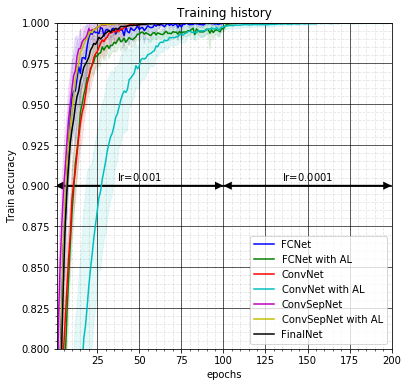

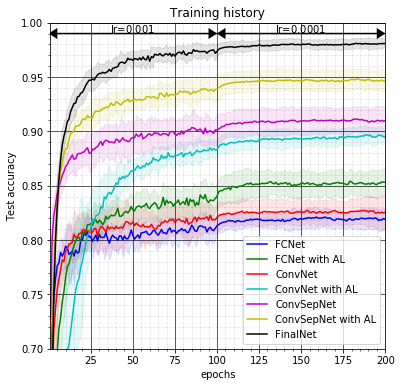

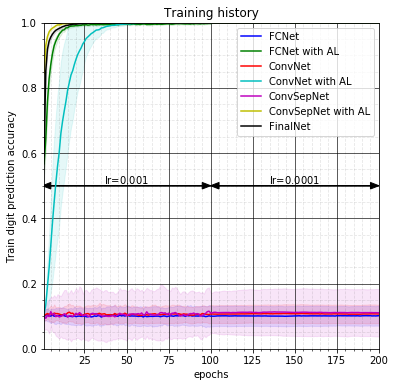

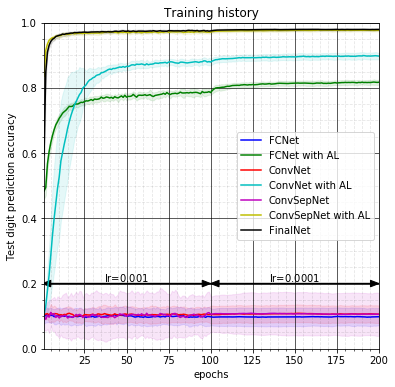

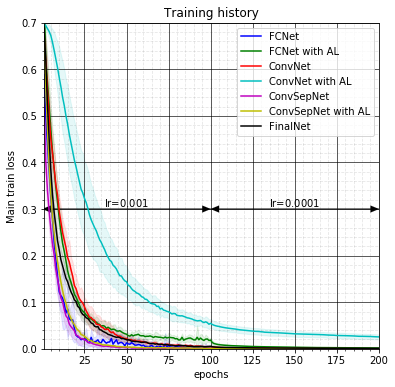

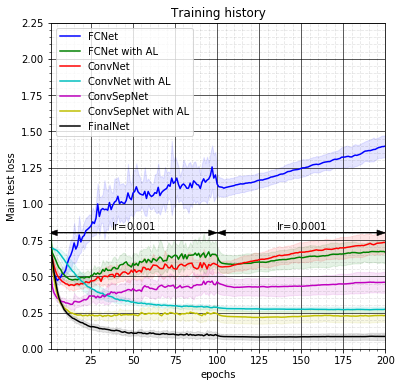

In [49]:
# Plot parameters

plot_history('tr_acc_hist', k=1, deviation=True, save=True,  start_epoch=0,
             y_lb = 0.8, y_ub = 1, pos_lgd = 4, ah = 0.10, lw = 0.001, aw = 0.005, s = 0.003)
plot_history('te_acc_hist', k=1, deviation=True, save=True,  start_epoch=0,
             y_lb = 0.7, y_ub = 1, pos_lgd = 4, ah = 0.29, lw = 0.1, aw = 0.01, s = 0.001)
plot_history('tr_acc_mnist_hist', k=1, deviation=True, save=True,  start_epoch=0,
             y_lb = 0.0, y_ub = 1, pos_lgd = 1, ah = 0.5, lw = 1, aw = 0.02, s = 0.006)
plot_history('te_acc_mnist_hist', k=1, deviation=True, save=True,  start_epoch=0,
             y_lb = 0.0, y_ub = 1, pos_lgd = 7, ah = 0.2, lw = 1, aw = 0.02, s = 0.006)
plot_history('tr_loss_hist', k=1, deviation=True, save=True,  start_epoch=0,
             y_lb = 0.0, y_ub = 0.7, pos_lgd = 1, ah = 0.3, lw = 0.1, aw = 0.015, s = 0.006)
plot_history('te_loss_hist', k=1, deviation=True, save=True,  start_epoch=0,
             y_lb = 0.0, y_ub = 2.25, pos_lgd = 2, ah = 0.8, lw = 0.5, aw = 0.04, s = 0.02)

Auxiliary loss analysis plots

In [142]:
def AL_plot(AL_stats_dict, measure, k=1, interp_p=False, scatter=False, minus_min=False, deviation=False, last=None, save=False,
             y_lb = -10, y_ub = 20, pos_lgd = 4):
    """Plot the specified measure for train and/or test results. measure must be acc or loss"""
    
    plt.figure(figsize=(6,6))
    f_legend = np.linspace(0, 1 ,NB_AL_EVAL)
    
    for model, stats in AL_stats_dict.items():
        if scatter:
            plt.scatter(f_legend[:last], 100 * (stats[0][measure].mean(0)[:last]- int(minus_min)*torch.min(stats[0][measure].mean(0)[0])), color=stats[1], marker='x', s=30, label=model)
        
            if interp_p:
                #Interpolation
                spl = interpolate.UnivariateSpline(f_legend[1:-1], 100 * (stats[0][measure].mean(0)[1:-1] - int(minus_min)*torch.min(stats[0][measure].mean(0)[0])), s=10, k=2)
                ynew = spl(f_legend[:-1])
                
                #Plotting interpolation 
                plt.plot(f_legend[1:-1], ynew[1:], color=stats[1], ls='--')
                
                #End of the graph at f=0,1
                plt.plot([f_legend[0],f_legend[1]], [0, ynew[1]], color = stats[1], ls=':')
                plt.plot([f_legend[-2],f_legend[-1]], [ynew[-1], -1], color = stats[1], ls=':')
        else:
            plt.plot(f_legend[:last], 100 * (stats[0][measure].mean(0)[:last]- int(minus_min)*torch.min(stats[0][measure].mean(0)[0])), color=stats[1], label=model)
            
            
        if deviation:
            plt.fill_between(f_legend[:last],
                             100 * (stats[0][measure].mean(0)[:last]- int(minus_min)*torch.min(stats[0][measure].mean(0)[0])) - k*stats[0][measure].std(0)[:last],
                             100 * (stats[0][measure].mean(0)[:last]- int(minus_min)*torch.min(stats[0][measure].mean(0)[0])) + k*stats[0][measure].std(0)[:last],
                             color=stats[1], alpha=.1)

    # Labels
    if measure == 'tr_acc_hist':
        lab = 'Train accuracy improvement [%]'
    elif measure == 'te_acc_hist':
        lab = 'Test accuracy improvement [%]'
    elif measure == 'tr_loss_hist':
        lab = 'Final main train loss'
    elif measure == 'te_loss_hist':
        lab = 'Final main test loss'
    elif measure == 'tr_acc_mnist_hist':
        lab = 'Train digit prediction accuracy [%]'
    elif measure == 'te_acc_mnist_hist':
        lab = 'Test digit prediction accuracy [%]'
    
    plt.title("Impact of Auxiliary Losses")
    plt.legend(loc=pos_lgd)
    plt.xlim((0, 1))
    plt.ylim((y_lb, y_ub))
    
    plt.minorticks_on()
    plt.grid(b=True, which='major', color='k', linestyle='-', alpha=0.8)
    plt.grid(b=True, which='minor', color='k', linestyle='--', alpha=0.1)
    plt.xlabel('f [-] ')
    plt.ylabel(lab )
    
    if save:
        plt.savefig('./figures/AL_' + measure + '_{}r_{}f.png'.format(stats[0][measure].shape[0], stats[0][measure].shape[1]))

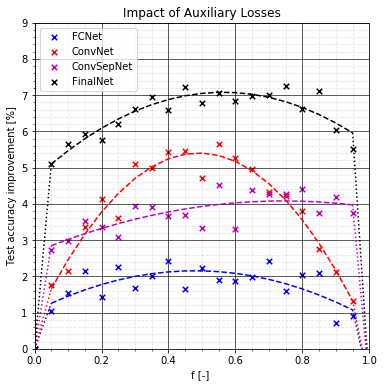

In [148]:
AL_stats_dict = {"FCNet": (AL_stats_FCNet, 'b'),
                 "ConvNet": (AL_stats_ConvNet, 'r'),
                 "ConvSepNet": (AL_stats_ConvSepNet, 'm'),
                 "FinalNet": (AL_stats_FinalNet, 'k')}

AL_plot(AL_stats_dict, 'te_acc_hist', k=1, interp_p=True, scatter=True, minus_min=True, deviation=False,
        last=-1, save=False,y_lb = 0, y_ub = 9, pos_lgd = 2)

#### Performance tracking

In [36]:
#Model : BasicNetV2 with MnistNetV3 
#Number of trained parameters : 50194
#Train data size : 1000
#Size of mini-batches : 15
#Number of epochs per round: 200
#Learning rate : 0.001 (multiplied by 0.1 every 100 epochs)
#Weight of auxiliary loss: 0.5
#Time for 10 rounds : 1351.07s
#Average main performance (and standard deviation):
#    -Train accuracy : 99.99% (+-0.03%)
#    -Test accuracy : 96.21% (+-0.62%)
#Average auxiliary performance (and standard deviation):
#    -Train Mnist accuracy : 100.00% (+-0.02%)
#    -Test Mnist accuracy : 97.20% (+-0.29%)

#Model : BasicNetV2 with MnistNetV4 
#Number of trained parameters : 57162
#Train data size : 1000
#Size of mini-batches : 15
#Number of epochs per round: 200
#Learning rate : 0.001 (multiplied by 0.1 every 100 epochs)
#Weight of auxiliary loss: 0.5
#Time for 10 rounds : 1321.99s
#Average main performance (and standard deviation):
#    -Train accuracy : 100.00% (+-0.00%)
#    -Test accuracy : 97.45% (+-0.32%)
#Average auxiliary performance (and standard deviation):
#    -Train Mnist accuracy : 100.00% (+-0.00%)
#    -Test Mnist accuracy : 97.39% (+-0.24%)

#Model : BasicNetV2 with MnistNetV5 
#Number of trained parameters : 57162
#Train data size : 1000
#Size of mini-batches : 15
#Number of epochs per round: 200
#Learning rate : 0.001 (multiplied by 0.1 every 100 epochs)
#Weight of auxiliary loss: 0.5
#Time for 10 rounds : 1183.94s
#Average main performance (and standard deviation):
#    -Train accuracy : 99.96% (+-0.10%)
#    -Test accuracy : 97.45% (+-0.75%)
#Average auxiliary performance (and standard deviation):
#    -Train Mnist accuracy : 99.96% (+-0.04%)
#    -Test Mnist accuracy : 97.23% (+-0.41%)

#Model : BasicNetV2 with MnistNetV6 
#Number of trained parameters : 60306
#Train data size : 1000
#Size of mini-batches : 15
#Number of epochs per round: 200
#Learning rate : 0.001 (multiplied by 0.1 every 100 epochs)
#Weight of auxiliary loss: 0.5
#Time for 10 rounds : 980.22s
#Average main performance (and standard deviation):
#    -Train accuracy : 99.99% (+-0.03%)
#    -Test accuracy : 97.51% (+-0.44%)
#Average auxiliary performance (and standard deviation):
#    -Train Mnist accuracy : 99.99% (+-0.02%)
#    -Test Mnist accuracy : 97.32% (+-0.31%)

#Model : BasicNetV2 with MnistNetV6 
#Number of trained parameters : 60306
#Train data size : 1000
#Size of mini-batches : 15
#Number of epochs per round: 200
#Learning rate : 0.001 (multiplied by 0.1 every 150.0 epochs)
#Weight of auxiliary loss: 0.25 before epoch 100.0 and 0.75 afterTime for 10 rounds : 973.07s
#Average main performance (and standard deviation):
#    -Train accuracy : 99.99% (+-0.03%)
#    -Test accuracy : 97.63% (+-0.57%)
#Average auxiliary performance (and standard deviation):
#    -Train Mnist accuracy : 99.97% (+-0.04%)
#    -Test Mnist accuracy : 97.37% (+-0.55%)

#Model : BasicNetV2 with MnistNetV7 
#Number of trained parameters : 365350
#Train data size : 1000
#Size of mini-batches : 15
#Number of epochs per round: 200
#Learning rate : 0.001 (multiplied by 0.1 every 100 epochs)
#Weight of main loss: 0.25 before epoch 50 and 0.75 after
#Time for 10 rounds : 1825.85s
#Average main performance (and standard deviation):
#    -Train accuracy : 100.00% (+-0.00%)
#    -Test accuracy : 98.09% (+-0.37%)
#Average auxiliary performance (and standard deviation):
#    -Train Mnist accuracy : 100.00% (+-0.00%)
#    -Test Mnist accuracy : 97.86% (+-0.20%)

#Model : BasicNetV2 with MnistNetV7 
#Number of trained parameters : 365350
#Train data size : 1000
#Seed for reproductibility : 1
#Size of mini-batches : 15
#Number of epochs per round: 200
#Learning rate : 0.001 (multiplied by 0.1 every 100 epochs)
#Weight of main loss: 0.25 before epoch 50 and 0.75 after
#Time for 10 rounds : 2433.78s
#Average main performance (and standard deviation):
#    -Train accuracy : 100.00% (+-0.00%)
#    -Test accuracy : 97.94% (+-0.56%)
#Average auxiliary performance (and standard deviation):
#    -Train Mnist accuracy : 100.00% (+-0.00%)
#    -Test Mnist accuracy : 97.74% (+-0.33%)

#Model : BasicNetV2 with MnistNetV7 
#Number of trained parameters : 365350
#Train data size : 1000
#Seed for reproductibility : 1
#Size of mini-batches : 15
#Number of epochs per round: 200
#Learning rate : 0.001 (multiplied by 0.1 every 100 epochs)
#Weight of main loss: 0.25 before epoch 200 and 0.75 after
#Time for 10 rounds : 2477.05s
#Average main performance (and standard deviation):
#    -Train accuracy : 100.00% (+-0.00%)
#    -Test accuracy : 98.07% (+-0.50%)
#Average auxiliary performance (and standard deviation):
#    -Train Mnist accuracy : 100.00% (+-0.00%)
#    -Test Mnist accuracy : 97.74% (+-0.25%)

#Model : BasicNetV2 with MnistNetV7 
#Number of trained parameters : 365350
#Train data size : 1000
#Seed for reproductibility : 1
#Size of mini-batches : 15
#Number of epochs per round: 200
#Learning rate : 0.001 (multiplied by 0.1 every 100 epochs)
#Weight of main loss: 0.5 before epoch 200 and 0.75 after
#Time for 10 rounds : 2484.46s
#Average main performance (and standard deviation):
#    -Train accuracy : 100.00% (+-0.00%)
#    -Test accuracy : 98.13% (+-0.51%)
#Average auxiliary performance (and standard deviation):
#    -Train Mnist accuracy : 100.00% (+-0.00%)
#    -Test Mnist accuracy : 97.79% (+-0.19%)

In [160]:
import time
import sys

for i in range(10):
    time.sleep(1)
    print('\rEpoch {}/{}'.format(i, 10), end="")
    #sys.stdout.write("\r%d%%" % i)
    #sys.stdout.flush()

Epoch 9/10